# <h1><center>DEEPGAUGE</center></h1>
## <h1><center>Analog Gauge Reading with Deep Learning using Tensorflow Custom Estimators</center></h1>


* Introduction
* Project Description
* Approach
Steps:
    * Data Generation, Preprocessing and the data pipeline
    * Data exploration with some commentary
    * TensorFlow model
        Ensembling
        Primary Models
        Custom Performance Metric
        Hyperparameter Tuning
        Feature Engineering
    * Training of model
    * Evaluation of model on independent dataset along with commentary
* Online prediction

# Introduction
This is a project to read dial reading from an analog gauge. Dial gauges are used in many industries to monitor various parameters like air/water pressure, temperature, stress/strain etc. Dial gauges are usually analog in nature and monitored manually in industries. Manual monitoring of gauges is tedious and prone to errors. Various approaches based on image processing using opencv and signal processing have been explored in industry. In this demo we explore a CNN based deep learning approach to read gauge dial readings using the images captured from mobile devices such a phones/raspberrypi. We use tensorflow custom estimators to reaized the task.

# Project Description

# Approach
Dataset collection is very important part of training deeplearning models. Obtaining a Gauge dial dataset requries images of gauge dial at different needle positions. Each gauge dial have unique construction and to train an effective model requires dataset consisting of images of the gauge dial at each needle position. Taking gauge images for every position in infeasbile as one cannot have access to gauges installed at the field or gauges reading may not be physically controllable. The approach for the Deep Gauge reader is to collect a gauge dial image for a single position and augument the image dataset with needle positions at different locations. The images are further agumented using rotation, translation and cropping to obtain sufficient dataset for training the model.



## Data Generation, Preprocessing and the Data pipeline

The block diagram below shows a snap of a gauge dial for a particular dial position. The needle and the background for the particular image is seperated using photshop tool. The needle image seperated from the gauge dial is rotated for all the required angles and added to the backgourd to get each candidate image for every label/class corresponding to gauge dial reading. To increase the dataset we augument the images using transformations like scaling, rotation, cropping etc. The dataset is trained on using tensorflow built upon custom estimator based on ensemble of models. 


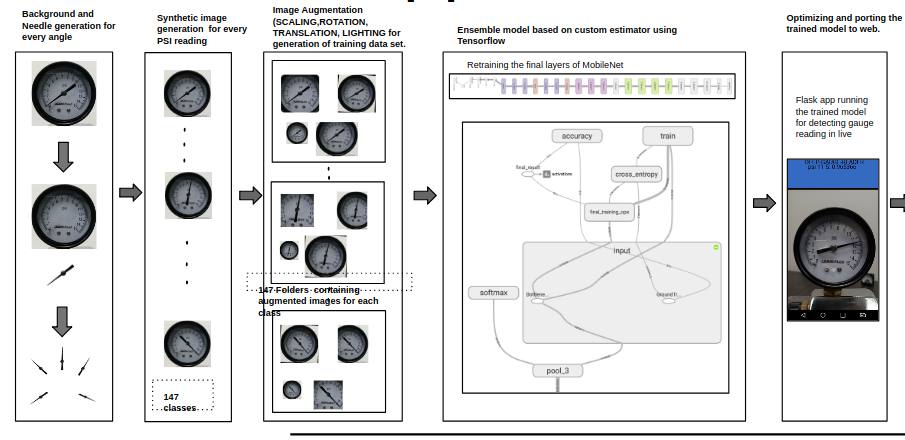

In [1]:
from IPython.display import Image
Image(filename='deepgauge.png')

## Synthetic Dial Gauge Dataset Generation 
For generating dataset for training the gauge reader, camera snap of a real gauge is taken and various images corresponding to the every dial position are synthetically generated using OpenCV libraries. To the synthetically generated images various tranforms such as scaling, rotation, zooming, translation are applied to augument the  dataset for training a deeplearning model.
### Correct Needle placement
* Determine what angle the needle needs to be set to in order to display at the 0 gauge number.
* Determine what angle the needle needs to be set to in order to display the 15 gauge reading.
* Iterate over the range between the 0 angle and the 15 angle
* Create the image with the labels in PSI instead of degrees.

In [2]:
import os
import numpy as np

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Declare variables
NEEDLE = './images/needle.png'
GAUGE = './images/gauge.png'

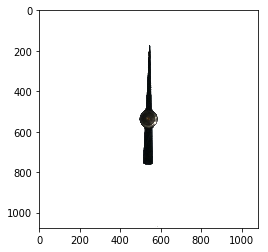

In [4]:
# Modify the image to set the needle at 0 degrees
image = Image.open(NEEDLE).convert('RGBA')
image_rot_90 = image.rotate(232, expand=False, resample=Image.BICUBIC)
# image_rot_90.save('needle_rot_0.png')
plt.imshow(image_rot_90)

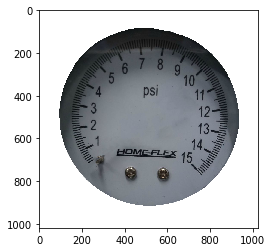

In [5]:
# Gauge background
image = Image.open(GAUGE).convert('RGBA')
plt.imshow(image)

### Needle image manipulation rotation and saving

In [6]:
# Rotate all the images of needles 360 degrees
PATH = "./images/needles/needle_rot_{0}.png"
def make_needles(angle):
    img = Image.open('needle_rot_0.png')
    x = img.rotate(-angle, expand=True, resample=Image.BICUBIC)
    # crop the rotated image to the size of the original image
    x = x.crop(box=(x.size[0]/2 - img.size[0]/2,
               x.size[1]/2 - img.size[1]/2,
               x.size[0]/2 + img.size[0]/2,
               x.size[1]/2 + img.size[1]/2))
    
    filename = PATH.format(angle)

    x.save(filename)

for angle in range(0, 361):
    make_needles(angle)

In [7]:
GAUGE_ROT = './images/needles/needle_rot_0.png'
GAUGE_ROT = './images/needles/needle_rot_45.png'
GAUGE_ROT = './images/needles/needle_rot_90.png'
GAUGE_ROT = './images/needles/needle_rot_135.png'

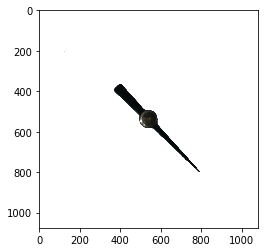

In [8]:
# Gauge background
image = Image.open(GAUGE_ROT).convert('RGBA')
plt.imshow(image)

In [9]:
# for i in range(4):
#     fig, ax  ==  plt.subplots(figsize = (10, 10))
#     plt.subplot(2, 2, i)
#     plt.imshow(X_imgs[i])
#     plt.title('Base Image')
#     plt.subplot(2, 2, 2)
#     plt.imshow(scaled_imgs[3])
#     plt.title('Scale = 0.90')
#     plt.subplot(2, 2, 3)
#     plt.imshow(scaled_imgs[4])
#     plt.title('Scale = 0.75')
#     plt.subplot(2, 2, 4)
#     plt.imshow(scaled_imgs[5])
#     plt.title('Scale = 0.60')
#     plt.show()

### Individual folder structure for Tensorflow training


In [10]:
# Create the folders for each of the gauge classes
PATH = './images/tf_gauges/psi_{0}'

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

m = range(0, 16)
n = range(1, 10)
o = range(5, 10)

for idx, i in enumerate(m):
    createFolder(PATH.format(i))
    
    # the gauge stops at 15
    if(i != 15):
        # loop through 0.5 - 1
        for kdx, k in enumerate(o):
            pre_one = "{0}-{1}".format(i,k)
            createFolder(PATH.format(pre_one))
        
    # loop through 1 - 15
    if(i >= 1 and i < 15):
        whole = "{0}".format(i)
        createFolder(PATH.format(whole))
        
        # Loop through #.1 = #.9
        if(i != 15):
            for jdx, j in enumerate(n):
                decimal = "{0}-{1}".format(i,j)
                createFolder(PATH.format(decimal))

### Generate synthetic gauges and save for Tensorflow training

In [11]:
NEEDLES_PATH = "./images/needles/needle_rot_{0}.png"
TF_GAUGES = "./images/tf_gauges/psi_{0}"
EDA_GAUGES = "./images/gauges/{0}"

def save_gauge(item, num):
    img_gauge = Image.open(GAUGE, 'r')

    filename = NEEDLES_PATH.format(item)
    img_needle = Image.open(filename, 'r')
    img_copy = img_gauge.copy()

    img_copy.paste(img_needle.convert('L'), (-28, -38), img_needle.convert('RGBA'))
    
    # Save the synthetic image to the class folder
    string_num = str(num)
    dash = string_num.replace(".","-")
    folder = TF_GAUGES.format(dash)

    # Save PNG for data Augmentation
    gauge_name = "{0}/gauge_0.png"
    filename_save = gauge_name.format(folder)
    img_copy.save(filename_save)

    # Save PNG for EDA
    eda_name = "gauge_{0}.png".format(dash)
    img_copy.save( EDA_GAUGES.format(eda_name) )

def iterate_gauge(mapping):
    for idx, item in enumerate(mapping):
        save_gauge(mapping[item], item)

In [12]:
# Define a mapping between degrees in circle and gauge readings
gaugeDegreeMap = {
    0:231, 0.5:233, 0.6:235, 0.7:237, 0.8:239, 0.9:241,
    1:243, 1.1:244, 1.2:246, 1.3:248, 1.4:249, 1.5:250, 1.6:253, 1.7:255, 1.8:257, 1.9:259,
    2:260, 2.1:262, 2.2:264, 2.3:266, 2.4:268, 2.5:270, 2.6:271, 2.7:273, 2.8:275, 2.9:277,
    3:279, 3.1:280, 3.2:282, 3.3:284, 3.4:286, 3.5:287, 3.6:290, 3.7:291, 3.8:293, 3.9:295,
    4:297, 4.1:299, 4.2:301, 4.3:302, 4.4:304, 4.5:306, 4.6:308, 4.7:310, 4.8:311, 4.9:313,
    5:315, 5.1:317, 5.2:319, 5.3:321, 5.4:323, 5.5:325, 5.6:327, 5.7:328, 5.8:330, 5.9:332,
    6:334, 6.1:336, 6.2:338, 6.3:339, 6.4:341, 6.5:343, 6.6:345, 6.7:347, 6.8:349, 6.9:350,
    7:352, 7.1:355, 7.2:357, 7.3:358, 7.4:360, 7.5:2, 7.6:4, 7.7:6, 7.8:7, 7.9:9,
    8:11, 8.1:13, 8.2:15, 8.3:16, 8.4:18, 8.5:21, 8.6:23, 8.7:24, 8.8:26, 8.9:28,
    9:30, 9.1:32, 9.2:33, 9.3:35, 9.4:37, 9.5:39, 9.6:41, 9.7:42, 9.8:44, 9.9:46,
    10:48, 10.1:50, 10.2:52, 10.3:53, 10.4:55, 10.5:57, 10.6:58, 10.7:60, 10.8:62, 10.9:64,
    11:66, 11.1:68, 11.2:69, 11.3:71, 11.4:73, 11.5:75, 11.6:76, 11.7:78, 11.8:80, 11.9:82,
    12:84, 12.1:85, 12.2:87, 12.3:89, 12.4:91, 12.5:92, 12.6:94, 12.7:96, 12.8:98, 12.9:99,
    13:101, 13.1:103, 13.2:105, 13.3:107, 13.4:108, 13.5:110, 13.6:112, 13.7:114, 13.8:115, 13.9:117,
    14:119, 14.1:121, 14.2:122, 14.3:124, 14.4:126, 14.5:127, 14.6:129, 14.7:131, 14.8:133, 14.9:135,
    15: 136
}

In [115]:
# Iterate through the lookup map
iterate_gauge(gaugeDegreeMap)

### Data Augmentation Techniques
* Scaling
* Translation
* Rotation (at 90 degrees)
* Rotation (at finer angles)
* Flipping
* Adding Salt and Pepper noise
* Lighting condition
* Perspective transform

In [116]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import os
import cv2
from math import floor, ceil, pi
import scipy
import glob
import imageio

%matplotlib inline

In [117]:
IMAGE_SIZE = 224

# Image Resizing
def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), 
                                    tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

#### Scaling:
Having differently scaled object of interest in the images is the most important aspect of image diversity. When your network is in hands of real users, the object in the image can be tiny or large. Also, sometimes, object can cover the entire image and yet will not be present totally in image (i.e cropped at edges of object). The code shows scaling of image centrally.

In [118]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

#### Translation:
We would like our network to recognize the object present in any part of the image. Also, the object can be present partially in the corner or edges of the image. For this reason, we shift the object to various parts of the image. This may also result in addition of a background noise. The code snippet shows translating the image at four sides retaining 80 percent of the base image

In [119]:
from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: # Translate left 5 percent
        offset = np.array([0.0, 0.05], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.95 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.95 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 5 percent
        offset = np.array([0.0, -0.05], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.95 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.95) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 5 percent
        offset = np.array([0.05, 0.0], dtype = np.float32)
        size = np.array([ceil(0.95 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.95 * IMAGE_SIZE)) 
    elif index == 3: # Translate bottom 20 percent
        offset = np.array([-0.05, 0.0], dtype = np.float32)
        size = np.array([ceil(0.95 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.95) * IMAGE_SIZE))
        h_end = IMAGE_SIZE
    elif index == 4: # Translate left 10 percent
        offset = np.array([0.0, 0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.9 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 5: # Translate right 10 percent
        offset = np.array([0.0, -0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE 
    elif index == 6: # Translate top 10 percent
        offset = np.array([0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.9 * IMAGE_SIZE))  
    elif index == 7: # Translate bottom 10 percent
        offset = np.array([-0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        h_end = IMAGE_SIZE      
        
        
    elif index == 8: # Translate right 20 percent
        offset = np.array([0.0, -0.03], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.97 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.97) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 9: # Translate top 20 percent
        offset = np.array([0.03, 0.0], dtype = np.float32)
        size = np.array([ceil(0.97 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    elif index == 10: # Translate bottom 20 percent
        offset = np.array([-0.03, 0.0], dtype = np.float32)
        size = np.array([ceil(0.97 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.97) * IMAGE_SIZE))
        h_end = IMAGE_SIZE
    elif index == 11: # Translate left 10 percent
        offset = np.array([0.0, 0.02], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.98 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.98 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 12: # Translate right 10 percent
        offset = np.array([0.0, -0.02], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.98 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.98) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE 
    elif index == 13: # Translate top 10 percent
        offset = np.array([0.02, 0.0], dtype = np.float32)
        size = np.array([ceil(0.98 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.98 * IMAGE_SIZE))  
    elif index == 14: # Translate bottom 10 percent
        offset = np.array([-0.02, 0.0], dtype = np.float32)
        size = np.array([ceil(0.98 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.98) * IMAGE_SIZE))
        h_end = IMAGE_SIZE    
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 15
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), 
				    dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
			 w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

#### Rotation (at 90 degrees):
The network has to recognize the object present in any orientation. Assuming the image is square, rotating the image at 90 degrees will not add any background noise in the image.

In [120]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

#### Rotation (at finer angles):
Depending upon the requirement, there maybe a necessity to orient the object at minute angles. However problem with this approach is, it will add background noise. If the background in image is of a fixed color (say white or black), the newly added background can blend with the image. However, if the newly added background color doesn’t blend, the network may consider it as to be a feature and learn unnecessary features.

In [121]:
from math import pi

def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

#### Flipping:
This scenario is more important for network to remove biasness of assuming certain features of the object is available in only a particular side. Consider the case shown in image example. You don’t want network to learn that tilt of banana happens only in right side as observed in the base image. Also notice that flipping produces different set of images from rotation at multiple of 90 degrees.My additional question is has anyone done some study on what is the maximum number of classes it gives good performance. Consider, data can be generated with good amount of diversity for each class and time of training is not a factor.

In [122]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

#### Adding Salt and Pepper noise:
Salt and Pepper noise refers to addition of white and black dots in the image. Though this may seem unnecessary, it is important to remember that a general user who is taking image to feed into your network may not be a professional photographer. His camera can produce blurry images with lots of white and black dots. This augmentation aides the above mentioned users.


In [126]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

#### Lighting condition:
This is a very important type of diversity needed in the image dataset not only for the network to learn properly the object of interest but also to simulate the practical scenario of images being taken by the user. The lighting condition of the images are varied by adding Gaussian noise in the image.

In [127]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [128]:
a=[]
a.append([2])
print(a)

[[2]]


#### Perspective transform:
In perspective transform, we try to project image from a different point of view. For this, the position of object should be known in advance. Merely calculating perspective transform without knowing the position of the object can lead to degradation of the dataset. Hence, this type of augmentation has to be performed selectively. The greatest advantage with this augmentation is that it can emphasize on parts of object in image which the network needs to learn.

In [129]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                     (X_img.shape[1], X_img.shape[0]),
                                     flags = cv2.INTER_LINEAR)
    return warped_img

## Generate and save augmented images into class folders

In [130]:
filename = 'gauge_0.png'
path = './images/tf_gauges/psi_{0}/{1}'

In [131]:
def resize_image(i, X_img):
    file_resized = "gauge_resized.jpg"
    filename_resized = path.format(i, file_resized)
    scipy.misc.imsave(filename_resized, X_img[0])

In [132]:
def scaled_image(folder, img):
    scale = [0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.84,0.83,0.82,0.81, 0.995,0.985,0.975,0.965,0.955,0.945,0.935,0.925,0.915,0.905,0.895,0.885,0.875,0.865,0.855,0.845,0.835,0.825,0.815]
    scaled_imgs = central_scale_images(img, scale)

    for i in range(0, 38):
        filename = "gauge_scale_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        scipy.misc.imsave(filepath, scaled_imgs[i])

In [133]:
def tranlate_image(folder, img):
    translated_imgs = translate_images(img)
    
    for i in range(0, 15):
        filename = "gauge_translate_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        scipy.misc.imsave(filepath, translated_imgs[i])

In [134]:
def rotate_general_image(folder, img):
    rotated = rotate_images(img, -5, 5, 24)
    
    for i in range(24):
        filename = "gauge_rotated_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        scipy.misc.imsave(filepath, rotated[i] )

In [135]:
def flipped_image(folder, img):
    flipped = flip_images(img)
    
    for i in range(3):
        filename = "gauge_flipped_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        scipy.misc.imsave(filepath, flipped[i] )

In [136]:
def salt_pepper(folder, img):
    salt = add_salt_pepper_noise(img)
    filename = "gauge_salt_pepper.jpg"
    filepath = path.format(folder, filename)
    scipy.misc.imsave(filepath, salt[0] )

In [137]:
def lighting(folder, img):
    gaussian = add_gaussian_noise(img)
    
#     for i in range(10):
#         filename = "gauge_gaussian_{0}.jpg".format(i)
#         filepath = path.format(folder, filename)
#         scipy.misc.imsave(filepath, gaussian[i] )    
    filename = "gauge_gaussian.jpg"
    filepath = path.format(folder, filename)
    scipy.misc.imsave(filepath, gaussian[0] )

In [141]:
dirList = glob.glob("./images/tf_gauges/*/*.png")
X_img_paths = ['{}'.format(file) for file in dirList]

In [142]:
def exec_images(i, img):
    # Resized Image
    resize_image(i, img)
    # Scale 97% - 60%
    scaled_image(i, img)
    # Tranlate the images
    tranlate_image(i, img)
    # Rotate the image 180, 270 degress
    rotate_general_image(i, img)
    # Flip the image
    flipped_image(i, img)
    # Add noise in pixels
    salt_pepper(i, img)
    # Lighting condition
    lighting(i, img)

In [144]:
m = range(0, 16)
n = range(1, 10)
o = range(5, 10)

for idx, i in enumerate(m):
    
    # the gauge stops at 15
    if(i != 15):
        
        # loop through 0.5 - 1
        for kdx, k in enumerate(o):
            pre_one = "{0}-{1}".format(i,k)

            X_img = path.format(pre_one, filename)
            X_resize = tf_resize_images([X_img])
            print(pre_one)
            exec_images(pre_one, X_resize)
        
    # loop through 1 - 15
    if(i >= 1 and i < 15):
        X_img = path.format(i, filename)
        X_resize = tf_resize_images([X_img])
    
        exec_images(i, X_resize)
        
        # Loop through #.1 = #.9
        if(i != 15):
            for jdx, j in enumerate(n):
                decimal = "{0}-{1}".format(i,j)
                X_img = path.format(decimal, filename)
                X_resize = tf_resize_images([X_img])
                print(decimal)
                print(X_resize)
                exec_images(decimal, X_resize)

0-5


/home/ms/anaconda3_2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.
/home/ms/anaconda3_2/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/home/ms/anaconda3_2/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys
/home/ms/anaconda3_2/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """
/home/ms/anaconda3_2/lib/python3.6/site-packages/ipykernel

0-6
0-7
0-8
0-9
1-5
1-6
1-7
1-8
1-9
1-1
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
1-2
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1

2-7
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
2-8
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ..

4-4
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
4-5
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ..

6-5
6-6
6-7
6-8
6-9
6-1
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
6-2
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]

7-7
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
7-8
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ..

9-4
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
9-5
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ..

11-5
11-6
11-7
11-8
11-9
11-1
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
11-2
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1.

12-7
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
12-8
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   

14-4
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
14-5
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   

## Data exploration with some commentary

## TensorFlow model


## Training of model


## Evaluation of model on independent dataset along with commentary(Results, Visualization, Model Evaluation)

# Online prediction